In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(ranking_metrics=["sma","sma_corr"])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label == "mixed" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)
print(len(filtered_portfolios))

12


In [8]:
# additional_portfolios = []
# for portfolio in portfolios:
#     if portfolio.timeframe.value == "week" and portfolio.position_type.label == "long" and portfolio.selection_type.label != "long_short":
#         for member in Indicator:
#             pm = copy.deepcopy(portfolio)
#             pm.ranking_metric = member.label
#             additional_portfolios.append(pm)

In [9]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            # price = Indicator.OPTIMAL.calculate(price,timeframe=rolling_window)
            price = Indicator.SMA.calculate(price,timeframe=rolling_window)
            price = Indicator.SMACorr.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [01:53<00:00, 98.84it/s]


In [10]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [11]:
analysises = []
for max_price in tqdm([1,2]):
    filtered_simulation = simulation[simulation["adjclose"]<=max_price].copy()
    for portfolio in filtered_portfolios:
        try:
            trades = portfolio.trades(filtered_simulation.copy())
            performance = portfolio.portfolio(trades.copy(),benchmark.copy())
            metrics = KPI.performance(trades,performance)
            results = {**portfolio.to_dict(),**metrics.copy()}
            results["portfolio"] = portfolio
            results["rolling_window"] = rolling_window
            results["max_price"] = max_price
            analysises.append(results)
        except Exception as e:
            print(str(e))
            continue

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


In [12]:
a = pd.DataFrame(analysises)

In [13]:
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values("pnl",ascending=False)
top = a.sort_values("pnl",ascending=False).head(20).to_dict("records")[0]
filtered_a.head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,pnl,raw_pnl,downside,coefficient_of_variation,portfolio_std,average_gain,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price
12,sma,long,STANDARD_DEV,mixed,0.1,12970.143938,367321.600114,0.909537,5.009114,2589.308737,1.080647,0.940823,0.490609,1.009422,5.007935,<financial_common.portfolio_management.portfol...,20,2
18,sma_corr,long,STANDARD_DEV,mixed,0.1,5960.284540,154794.351073,0.900000,4.519469,1318.801817,1.082381,0.940792,0.487603,1.009831,4.517153,<financial_common.portfolio_management.portfol...,20,2
20,sma_corr,long,ROLLING_DOLLAR_VOLUME,mixed,0.1,4723.628781,30540.503309,0.900000,3.391746,1392.683679,1.076241,0.939392,0.484974,1.005760,3.389518,<financial_common.portfolio_management.portfol...,20,2
17,sma,long,DISTANCE,mixed,0.1,3782.597086,133232.141387,0.900000,3.258693,1160.771137,1.075703,0.941373,0.476334,1.005359,3.256062,<financial_common.portfolio_management.portfol...,20,2
0,sma,long,STANDARD_DEV,mixed,0.1,3429.166258,11283.572714,0.900000,4.312736,795.125432,1.067594,0.945940,0.496060,1.006287,4.308894,<financial_common.portfolio_management.portfol...,20,1
14,sma,long,ROLLING_DOLLAR_VOLUME,mixed,0.1,3329.543909,21477.027292,0.900000,3.360856,990.683422,1.074166,0.939724,0.478963,1.004116,3.357725,<financial_common.portfolio_management.portfol...,20,2
22,sma_corr,long,DRAWDOWN,mixed,0.1,3079.039909,21075.635566,0.900000,3.703168,831.460953,1.064234,0.943325,0.496431,1.003348,3.699495,<financial_common.portfolio_management.portfol...,20,2
23,sma_corr,long,DISTANCE,mixed,0.1,2849.693114,77210.513032,0.900000,3.462826,822.938652,1.078452,0.941124,0.477836,1.006744,3.459114,<financial_common.portfolio_management.portfol...,20,2
11,sma_corr,long,DISTANCE,mixed,0.1,2705.706872,7130.490800,0.900000,5.563565,486.326096,1.065690,0.945563,0.489165,1.004325,5.557302,<financial_common.portfolio_management.portfol...,20,1
6,sma_corr,long,STANDARD_DEV,mixed,0.1,2424.344338,8193.780384,0.900000,3.984083,608.507446,1.068306,0.945762,0.491529,1.005996,3.979063,<financial_common.portfolio_management.portfol...,20,1


In [14]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [15]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

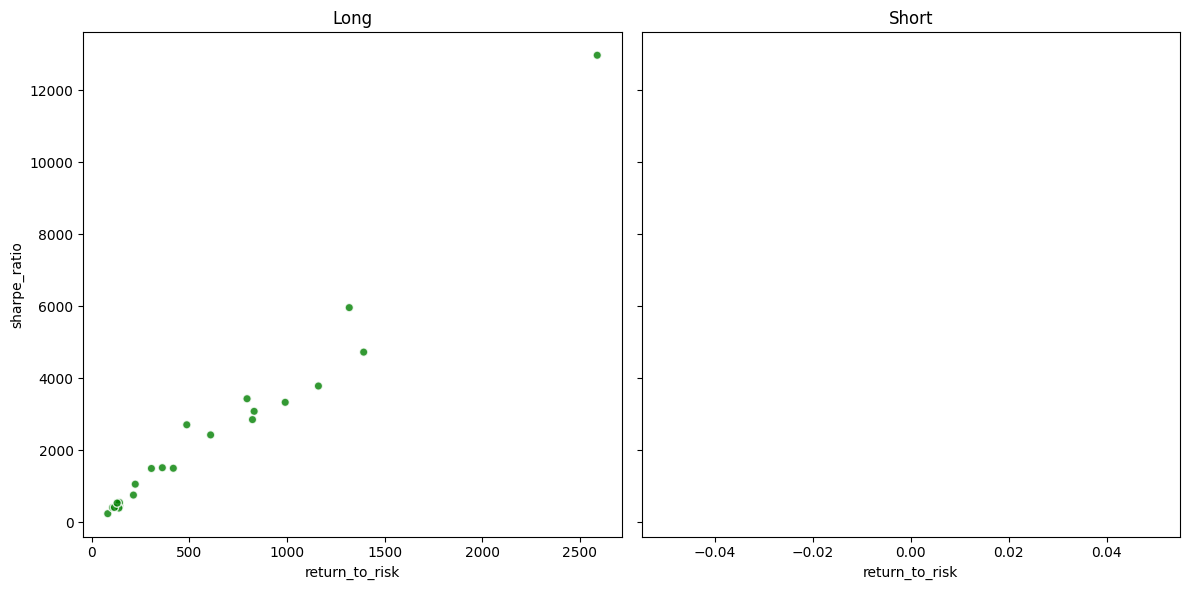

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [17]:
pm = top["portfolio"]
filtered_simulation = simulation[simulation["adjclose"]<=top["max_price"]]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

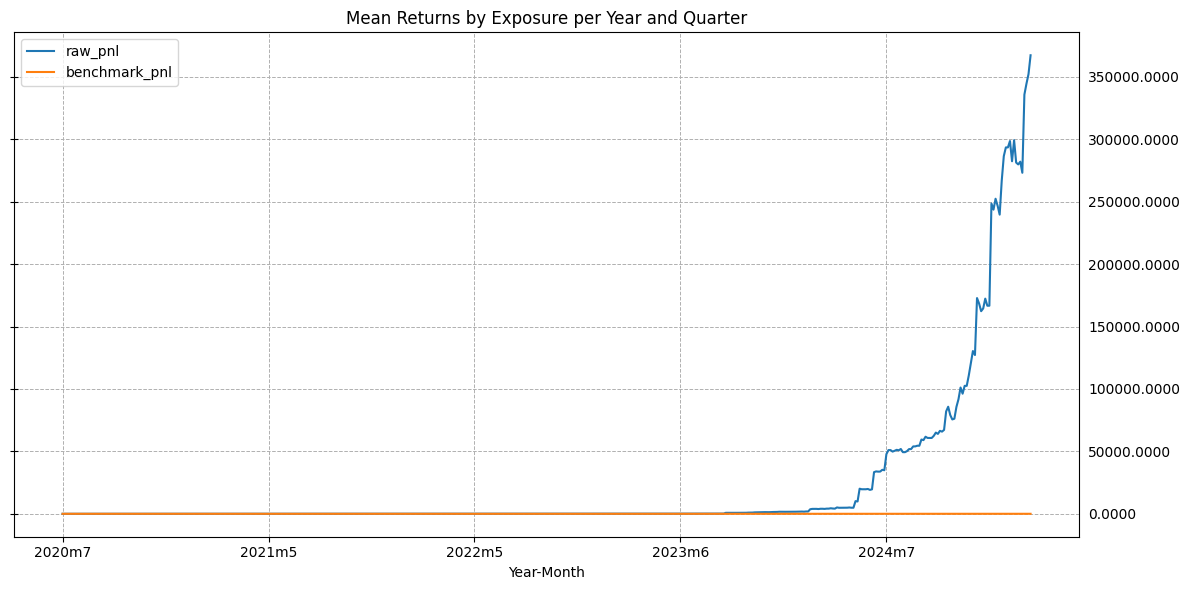

In [18]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [19]:
trades[["ticker","return"]].groupby("ticker").mean().sort_values("return",ascending=False)

,return
ticker,
IAUX,1.428392
ADIL,1.428392
GOVX,1.428392
AMTX,1.387324
SISI,1.296660
...,...
IMCC,0.900000
UMAC,0.900000
GP,0.900000


In [20]:
len(filtered_simulation["ticker"].unique())

1092

In [21]:
trades.sort_values("return",ascending=False).dropna().head(20)

,year,week,ticker,date,adjclose,sell_price,standard_dev,sma,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,,,
2020_30_1.0,2020,30,OCGN,2020-07-24 00:00:00+00:00,0.2480,0.3769,0.014691,0.066425,0.071270,1.0,0.143,1.0,1,1.519758,1.519758,1.428392,1.519758,1.428392,7,3
2025_6_0.8,2025,6,IVVD,2025-02-06 00:00:00+00:00,1.0600,1.9800,0.051775,0.218731,0.320397,0.8,0.018,1.0,1,1.867925,1.867925,1.428392,1.867925,1.428392,2,1
2025_19_0.7,2025,19,GRYP,2025-05-09 00:00:00+00:00,0.3300,0.5200,0.058215,-0.306679,0.317179,0.7,1.000,1.0,1,1.575758,1.575758,1.428392,1.575758,1.428392,5,2
2023_39_0.7,2023,39,FEMY,2023-09-28 00:00:00+00:00,0.3316,1.5200,0.055953,0.247629,0.147841,0.7,0.029,1.0,1,4.583836,4.583836,1.428392,4.583836,1.428392,9,3
2025_18_0.8,2025,18,GORO,2025-05-02 00:00:00+00:00,0.3800,0.6346,0.052430,0.210427,0.110726,0.8,0.014,1.0,1,1.670000,1.670000,1.428392,1.670000,1.428392,5,2
2023_44_1.0,2023,44,QVCGA,2023-11-03 00:00:00+00:00,0.0811,0.1223,0.007569,0.185310,0.076371,1.0,0.048,1.0,1,1.508015,1.508015,1.428392,1.508015,1.428392,11,4
2023_31_0.2,2023,31,ASPI,2023-08-04 00:00:00+00:00,1.1100,1.7100,0.147393,-0.434083,0.242288,0.2,1.000,1.0,1,1.540541,1.540541,1.428392,1.540541,1.428392,8,3
2023_30_0.5,2023,30,ASPI,2023-07-28 00:00:00+00:00,0.6718,1.2100,0.071091,-0.139696,0.111575,0.5,1.000,1.0,1,1.801131,1.801131,1.428392,1.801131,1.428392,7,3
2023_42_0.8,2023,42,CTM,2023-10-20 00:00:00+00:00,0.2399,0.3500,0.042488,0.203424,0.166679,0.8,0.026,1.0,1,1.458941,1.458941,1.428392,1.458941,1.428392,10,4


In [22]:
portfolio.sort_values("weighted_return",ascending=False)

,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,year,month,quarter,week,Year-Month
322,2023-09-28 00:00:00+00:00,4.583836,1.428392,187.426675,782.701650,141.43,1.614682,2023,9,3,39,2023m9
385,2024-05-16 00:00:00+00:00,2.085714,1.428392,1125.766483,10138.190758,197.80,2.258249,2024,5,2,20,2024m5
387,2024-05-23 00:00:00+00:00,2.035349,1.185715,1300.584875,20105.245541,192.38,2.196369,2024,5,2,21,2024m5
363,2024-02-28 00:00:00+00:00,1.975369,1.428392,590.804353,3636.744589,179.08,2.044526,2024,2,1,9,2024m2
394,2024-06-20 00:00:00+00:00,1.702703,1.428392,1810.671927,33365.825865,194.09,2.215892,2024,6,2,25,2024m6
...,...,...,...,...,...,...,...,...,...,...,...,...
131,2021-09-16 00:00:00+00:00,0.929648,0.929648,7.158581,7.337772,142.76,1.629866,2021,9,3,37,2021m9
35,2020-10-29 00:00:00+00:00,0.925184,0.925184,3.142354,3.155046,86.12,0.983217,2020,10,4,44,2020m10
108,2021-06-29 00:00:00+00:00,0.922652,0.922652,6.617976,6.783634,138.40,1.580089,2021,6,2,26,2021m6
431,2024-10-23 00:00:00+00:00,0.922297,0.922297,4285.909717,79101.775768,220.79,2.520722,2024,10,4,43,2024m10
